# Exercise 09: Distance Based Utility Model

- Agent's utility depends on \textbf{direct} \textbf{and} \textbf{indirect} connections
    - Connections are \textbf{undirected} $\to$ counted twice
    - Number of direct connections (\textbf{links}):  Degree $d_{i}$ 
    - \textbf{Length} $l_{ij}$ of \textbf{shortest path} between $i$ and $j$ (\# of hops)
    - If $(i,j)$ are not connected by a path: $l_{ij}\to \infty$
    - \textbf{Benefit} $b(l)$ \textbf{decreases}  with distance $l$
    - \textbf{Cost} per link is constant, $c$, agents maintain their direct links
- *Utility* of agent $i$: $$ u_{i} = \sum_{j \neq i} b(l_{ij}) - c\,d_i $$
    1. Choice of $b(l)$: $\delta^{l}$ with $0<\delta<1$ $\to \delta$, $\delta^{2}$, ... (``connections model'')
    2. Choice of $b(l)$: $b(1)=b_{1}>b(2)=b_{2}$, $b(l>2)=0$
- item Is it beneficial for agents to create links?
    - Reduce costs $\to$ less \textbf{direct} links 
    - Increase benefits $\to$ more \textbf{direct/indirect} links, dependent on $b_{1}$, $b_{2}$


In [52]:
import mesa
import numpy as np
import networkx as nx
import random

from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import networkx as nx
import numpy as np

import matplotlib.pyplot as plt

## Section 1: Implement customs schedulers

Mesa's RandomActivation scheduler activates all agents in a random order at each step.
If we want to see how the different activation orders affect the model, we need to implement a custom scheduler that will activate agents in a random order, but only once per step.

`RandomSingleActivation` provides the code for a custom scheduler that activates one agent at random per step.
However, the same agent may be activated multiple times before all agents have been activated once.
Modify this code to create a custom scheduler that activates agents in a random order, ensuring that all agents are activated once before any agent is activated a second time.

In [53]:
class RandomSingleActivation(mesa.time.BaseScheduler):
    """A scheduler to activate only one random agent per step."""
    def step(self):
        if self.agents:
            agent = random.choice(self.agents)
            agent.step()
            
        self.steps += 1
        self.time += 1


In [54]:

class RandomOrderedSingleActivation(mesa.time.BaseScheduler):
    """
    A scheduler to activate only one random agent per step. The order of agents is shuffled. 
    An agent is activated again only after all other agents have been activated.
    """
    self.unactivated_agents = self.agents.copy()
    def step(self):
        if self.agents:
            agent = random.choice(self.unactivated_agents)
            agent.step()
            self.unactivated_agents.remove(agent)

        self.steps+=1
        self.time+=1

## Section 2: Implement the Distance Based Utility Model
Implement two variants of the benefit funtion:
- `benefit1`: $b(l) = \delta^{l}$ with $0<\delta<1$
- `benefit2`: $b(1)=b_{1}>b(2)=b_{2}$, $b(l>2)=0$

### Complete the model class using the skeleton code provided below

In [55]:
class Agent(mesa.Agent):
    """
    Agent class for the network formation model.
    """

    def __init__(self, model:"World", unique_id):
        super().__init__(unique_id, model)
    
    # ==== Properties ====
    # implement properties of the agent that are useful for the model, especially with respect to its position in the network
    # some are already provided, but you may need to add more
    
    @property
    def uid(self):
        """unique agent identifier, useful for matching agents to network nodes"""
        return self.unique_id

    def subgraph(self, network = None, copy=False):
        """The graph induced by selecting only the component to which the agent belongs."""
        if network is None:
            my_component = self.component_uids()
            network = self.model.net
        else:
           my_component = self.component_uids(network)

        sub_graph = nx.subgraph(network, my_component)
        if copy:
            return sub_graph.copy()
        return sub_graph
    
    def component_uids(self, network = None):
        """returns the uids of the component in which this agent resides"""
        if network is None:
            network = self.model.net
        my_comp = [c for c in nx.connected_components(network) if self.uid in c][0]
        return my_comp


    # === Basic Actions ===
    # implement the basic actions of the agent

    # === agent decisions ===
    def utility(self, subgraph):
        """
        The utility for the agent given his position in the network."""
        return 0

    # === Update Rules ===
    def perform_best_action(
        self, mutual_creation=True, mutual_deletion=False, max_sample=None
    ):
        """
        Create/Delete a link or do nothing according to the action that maximizes the agent's utility.
        mutual_creation: bool, whether the agent can create a link with another agent only if the link benefits the second agent as well.
        mutual_deletion: bool, whether the agent can delete a link with another agent only if the link deletion benefits the second agent as well.
        """
        pass

    def step(self):
        max_sample = self.model.max_sample
        mutual_create = self.model.mutual_create
        mutual_delete = self.model.mutual_delete

        # perform the best action available

The Model class provided already contains the basic structure of the model.
Add further methods to the class according to your implementation of the agents.

The `stability checks` provided below can be used to stop the simulation once the model reaches a stable state.
By default, stability is never checked every time step. Set `check_stability` to 1 to evaluate at every time steps, or to larger values to check less often.

By default, the model collects data on the number of links and the utility of each agent at each step.
You reduce the data collection frequency by increasing `poling_interval`.

If you want to plot the network at every data collection step, set `plot_network` to `True`.

In [66]:
# Model class
class World(mesa.Model):
    """The World class represents the environment in which the Agents interact.

    The class keeps track of the Network on which the agents interact, the alterations to it
    over time as well as the model time
    """

    def __init__(self, num_agents, cost,
                 mutual_create, 
                 mutual_delete,
                 delta,
                    b1,
                    b2,
                 poling_interval=1, 
                 check_stability=None, 
                 max_steps=None,
                 max_sample=None,
                 plot_network=False
                 ):
        super().__init__()
        self.schedule = RandomSingleActivation(self)
        self.net = nx.Graph()
        self.max_sample = max_sample
        self.cost = cost
        self._id_counter = 0
        self.poling_interval = poling_interval
        self.check_stability = check_stability
        if not self.check_stability and max_steps:
            self.check_stability = max_steps + 1
        else:
            self.check_stability = 1
        self.mutual_create = mutual_create
        self.mutual_delete = mutual_delete
        self.max_steps = max_steps
        self.num_agents = num_agents
        self.delta = delta
        self.b1 = b1
        self.b2 = b2
        self.plot = plot_network

        self.add_agents(num_agents)

        self.datacollector = DataCollector(
            {
                "welfare": lambda m: m.aggregate_welfare(),
                "density": lambda m: m.density(),
                "clustering": lambda m: m.clustering(),
                "num_components": lambda m: len(list(m.connected_components())),
            }
        )

    # === Basic Actions ===

    def _generate_uid(self):
        """generate a unique uid"""
        valid_id_found = False
        uid = None
        while not valid_id_found:
            uid = self._id_counter
            valid_id_found = uid not in self.net
            self._id_counter += 1
        return uid

    def add_agents(self, num_agents):
        """Add the specified number of agents or ids in agent_list to the World.
        """
        for _ in range(num_agents):
            self.add_agent()

    def add_agent(self):
        """Add a single Agent to the simulation
        """
        uid = self._generate_uid() # generate a unique uid for the agent in the network
        if uid in self.net:
            raise KeyError(f"`uid={uid}` already taken")

        agent = Agent(self, uid)
        self.schedule.add(agent)
        self.net.add_node(uid)

    # === Network properties (for reporting) ===
    def aggregate_welfare(self):
        """Compute aggregated welfare (i.e. the sum of all utilities) of the agents in the network
        """
        welfare = sum(a.utility(a.subgraph()) for a in self.schedule.agents)
        return welfare

    def density(self):
        """Returns the proportion of possible edges which are actually present"""
        return nx.density(self.net)

    def clustering(self):
        """See networkx.average_clustering"""
        return nx.average_clustering(self.net)

    def connected_components(self):
        """Returns a generator containing the uids of the current network

        Yields:
            sets of uids in the same component
        """
        return nx.connected_components(self.net)

    # === Stability Checks (to stop simulation) ===
    def is_pairwise_stable(self, agents=None, mutual_create=True, mutual_delete=True):
        """Return true if no agent would be willing to make a change (either create or delete)

        Args:
            agents (list of Agents): if the stability should only be checked for this subset pass a
                list of agents otherwise the stability is computed considering all agents
            mutual_create (bool): require that neither agent is worse off when creating the link
            mutual_delete (bool): require that neither agent is worse off when deleting the link

        Returns:
            Returns True if no agent wants to make a move, False otherwise
        """
        # short circuit logic to reduce the number of comparisons necessary to find that the
        # system is not stable (i.e. at least one agent wants to make a move).
        # If it is in fact stable all agents need to be tested
        deletion_stable = self.is_deletion_stable(agents, mutual=mutual_delete)

        if deletion_stable is False:  # the first test is False -> all is False
            return False

        # The first test has yielded True if the next test is False -> all is False
        creation_stable = self.is_creation_stable(agents, mutual=mutual_create)
        return creation_stable

    def is_deletion_stable(self, agents=None, mutual=True):
        """Returns True if no Agent would be willing to delete a link"""
        return self._is_simple_action_stable(agents, create=False, mutual=mutual)

    def is_creation_stable(self, agents=None, mutual=True):
        """Returns True if no Agent would be willing to create one more edge"""
        return self._is_simple_action_stable(agents, create=True, mutual=mutual)

    def _is_simple_action_stable(self, agents=None, create=True, mutual=True):
        """Given either create=True or create=False (i.e. delete) the function returns True if no
        Agent would be willing to perform an action of the given type."""
        if agents is None:
            agents = self.schedule.agents

        for agent in agents:
            _, other_agent = agent.best_simple_action(create, mutual)
            if other_agent is not None:
                return False
        return True
    
    def step(self):
        # at given interval report on the state of the system
        if self.schedule.time % self.poling_interval == 0:
            self.datacollector.collect(self)
            if self.plot:
                plot_network(world)
                plt.show()
            
        self.schedule.step()
        check_stability = self.check_stability
        mutual_create = self.mutual_create
        mutual_delete = self.mutual_delete
    

        if self.schedule.time>0 and check_stability and (self.schedule.time % check_stability == 0):
            print(check_stability)
            if self.is_pairwise_stable(
                mutual_create=mutual_create, mutual_delete=mutual_delete
            ):
                self.running = False
        
        if self.max_steps and self.schedule.time >= self.max_steps:
            self.running = False

## Section 3: Run the model and explore the parameter space.
- Do your results match what was discussed in the lecture?
- What happens if you start with a network with no links?
- What happens if you start with a network with all possible links?
- What happens if you change the cost of maintaining a link?
- What happens if you change the benefit function?
- What happens if links can be created also if they do not benefit both agents (mutual_create=False)?
- What happens if links can be destroyed only if the deletion benefits both agents (mutual_destroy=True)?

In [67]:
# the file visualtization functions provides you with some functions to plot the network
from visualization_functions import *

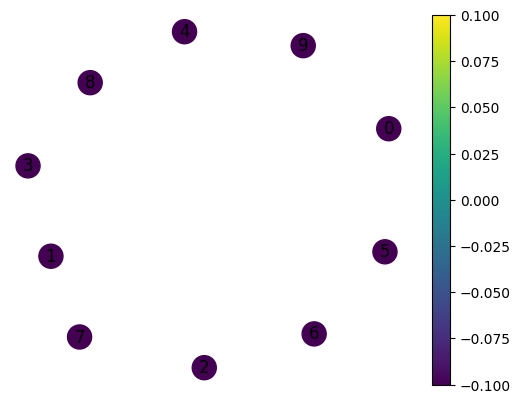

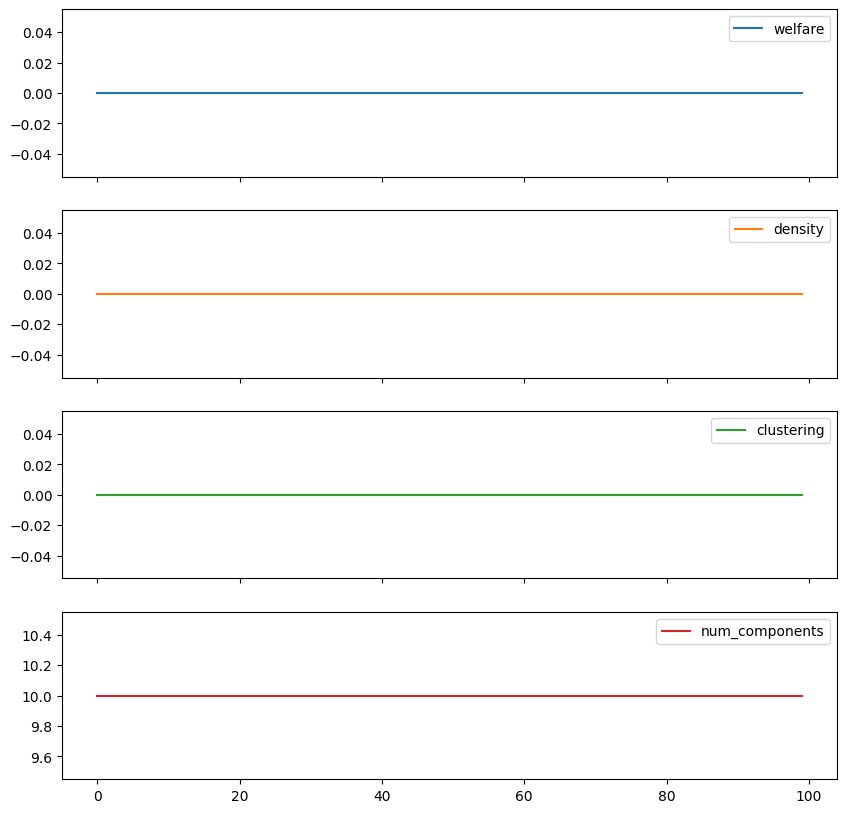

In [68]:
world = World(num_agents=10,
              cost=0,  
              mutual_create=True,
              mutual_delete=False,
              b1 = 0.9, b2 = 0.4,
              delta = .9,
              max_steps=100)
world.run_model()
plot_network(world)
plt.show()

df = world.datacollector.get_model_vars_dataframe()
df.plot(subplots=True, figsize=(10, 10))
plt.show()